In [1]:
from hossam import *
from pandas import DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error)

from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

In [5]:
from IPython.display import display
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin

class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10.0, check_cols=None):
        self.threshold = threshold
        self.check_cols = check_cols

    def _compute_vifs(self, X: pd.DataFrame):
        exog = sm.add_constant(X, prepend=True)
        
        vifs = {}
        for i, col in enumerate(X.columns):
            try:
                # statsmodels의 VIF 계산 시 상수항(const) 위치를 고려하여 i + 1 사용
                vifs[col] = float(variance_inflation_factor(exog.values, i + 1))
            except Exception:
                vifs[col] = float("inf")

        vdf = pd.DataFrame(vifs.items(), columns=["Variable", "VIF"])
        return vdf.sort_values("VIF", ascending=False)

    def fit(self, X, y=None):
        df = X.copy().dropna()

        self.vif_cols_ = self.check_cols if self.check_cols else df.columns.tolist()
        X_vif = df[self.vif_cols_].copy()

        self.drop_cols_ = []
        i = 0

        while True:
            if X_vif.shape[1] == 0:
                break

            print(f"\nVIF 제거 반복 {i+1}회차 =====================")
            vdf = self._compute_vifs(X_vif)
            max_vif = vdf.iloc[0]["VIF"]
            max_col = vdf.iloc[0]["Variable"]

            if max_vif <= self.threshold:
                print(
                    "모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 {0}개.".format(
                        i
                    )
                )
                break

            X_vif = X_vif.drop(columns=[max_col])
            self.drop_cols_.append(max_col)
            print(f"제거된 변수: {max_col} (VIF={max_vif:.2f})")
            i += 1

        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols_, errors="ignore")

In [2]:
def hs_get_scores(estimator, x_test, y_true):
    if hasattr(estimator, 'named_steps'):
        classname = estimator.named_steps['model'].__class__.__name__
    else:
        classname = estimator.__class__.__name__

    y_pred = estimator.predict(x_test)

    return pd.DataFrame(
        {
            "결정계수(R2)": r2_score(y_true, y_pred),
            "평균절대오차(MAE)": mean_absolute_error(y_true, y_pred),
            "평균제곱오차(MSE)": mean_squared_error(y_true, y_pred),
            "평균오차(RMSE)": np.sqrt(mean_squared_error(y_true, y_pred)),
            "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(
                y_true, y_pred
            ),
            "평균 비율 오차(MPE)": np.mean((y_true - y_pred) / y_true * 100),
        },
        index=[classname],
    )

In [23]:
def hs_learning_cv(
    estimator,
    x,
    y,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
):
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52,
    )

    if hasattr(estimator, 'named_steps'):
        classname = estimator.named_steps['model'].__class__.__name__
    else:
        classname = estimator.__class__.__name__

    # neg RMSE -> RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지점 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]
    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv

    # ------------------
    # 과소적합 기준선 (some_threshold)
    # ------------------
    # 기준모형 RMSE (평균 예측)
    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))

    # 분산 기반
    std_y = y.std()

    # 최소 설명력(R^2) 기반
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))

    # 최종 threshold (가장 관대한 기준)
    # -> 원래 some_threshold는 도메인 지식 수준에서 이 모델은 최소 어느 정도의 성능은 내야 한다는 기준을 설정하는 것
    some_threshold = min(rmse_naive, std_y, rmse_r2)

    # ------------------
    # 판정 로직
    # ------------------
    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = "⚠️ 과소적합 (bias 큼)"
    elif gap_ratio <= 0.8:
        status = "⚠️ 과대적합 (variance 큼)"
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = "✅ 일반화 양호"
    elif var_ratio > 0.15:
        status = "⚠️ 데이터 부족 / 분산 큼"
    else:
        status = "⚠️ 판단 유보"

    # ------------------
    # 정량 결과 표
    # ------------------
    result_df = DataFrame(
        {
            'Train RMSE':[final_train],
            'CV RMSE 평균':[final_cv],
            'CV RMSE 표준편차':[final_std],
            'Train/CV 비율':[gap_ratio],
            'CV 변동성 비율':[var_ratio],
            '판정 결과':[status]
        },
        index=[classname]
    )

    # display(result_df)

    # ------------------
    # 학습곡선 시각화
    # ------------------
    figsize = (1280 / my_dpi, 720 / my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.lineplot(
        x=train_sizes,
        y=train_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="Train RMSE",
    )
    
    sb.lineplot(
        x=train_sizes,
        y=cv_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="Train RMSE",
    )

    ax.set_xlabel("RMSE", fontsize=8, labelpad=5)
    ax.set_ylabel("학습곡선 (Learning Curve)", fontsize=8, labelpad=5)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

    return result_df

In [8]:
def hs_get_score_cv(estimator, x_test, y_test, x_origin, y_origin, scoring='neg_root_mean_squared_error', cv=5, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1):
    score_df=hs_get_scores(estimator, x_test, y_test)
    cv_df=hs_learning_cv(estimator, x_origin, y_origin, scoring=scoring, cv=cv, train_sizes=train_sizes, n_jobs=n_jobs)
    return merge(score_df, cv_df, left_index=True, right_index=True)

In [9]:
origin=load_data('restaurant_sales_preprocessed')
origin.set_index('date', inplace=True)
origin['holiday']=origin['holiday'].astype('category')
origin['weekend']=origin['weekend'].astype('category')
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 23.0 KB


In [10]:
df=origin

yname='sales'
x=df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=52)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

In [11]:
score_df = DataFrame(
    [
        [
            "Linear",
            0.709,
            0.156,
            0.042,
            0.204,
            0.010,
            0.225,
            0.198,
            0.203,
            0.012,
            0.973,
            0.060,
            "⚠️ 판단 유보",
        ],
        [
            "Ridge",
            0.708,
            0.156,
            0.042,
            0.205,
            0.010,
            0.219,
            0.198,
            0.203,
            0.012,
            0.974,
            0.058,
            "⚠️ 판단 유보",
        ],
        [
            "Lasso",
            0.707,
            0.155,
            0.042,
            0.205,
            0.009,
            0.221,
            0.199,
            0.204,
            0.011,
            0.978,
            0.055,
            "⚠️ 판단 유보",
        ],
        [
            "ElasticNet",
            0.709,
            0.156,
            0.042,
            0.204,
            0.010,
            0.223,
            0.198,
            0.203,
            0.012,
            0.974,
            0.059,
            "⚠️ 판단 유보",
        ],
        [
            "SGD",
            0.700,
            0.160,
            0.043,
            0.207,
            0.010,
            0.229,
            0.203,
            0.210,
            0.010,
            0.964,
            0.046,
            "⚠️ 판단 유보",
        ],
        [
            "KNN",
            0.635,
            0.178,
            0.052,
            0.229,
            0.011,
            0.301,
            0.000,
            0.220,
            0.020,
            0.000,
            0.090,
            "⚠️ 과대적합 (variance 큼)",
        ],
        [
            "DecisionTree",
            0.620,
            0.196,
            0.054,
            0.233,
            0.012,
            0.353,
            0.224,
            0.245,
            0.018,
            0.912,
            0.072,
            "✅ 일반화 양호",
        ],
        [
            "SVR",
            0.701,
            0.157,
            0.043,
            0.207,
            0.010,
            0.233,
            0.196,
            0.206,
            0.011,
            0.949,
            0.055,
            "✅ 일반화 양호",
        ],
    ],
    columns=[
        "모델",
        "결정계수(R2)",
        "MAE",
        "MSE",
        "RMSE",
        "MAPE",
        "MPE",
        "Train RMSE",
        "CV RMSE 평균",
        "CV RMSE 표준편차",
        "Train/CV 비율",
        "CV 변동성 비율",
        "판정 결과",
    ],
)
score_df

,모델,결정계수(R2),MAE,MSE,RMSE,MAPE,MPE,Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
0,Linear,0.709,0.156,0.042,0.204,0.010,0.225,0.198,0.203,0.012,0.973,0.060,⚠️ 판단 유보
1,Ridge,0.708,0.156,0.042,0.205,0.010,0.219,0.198,0.203,0.012,0.974,0.058,⚠️ 판단 유보
2,Lasso,0.707,0.155,0.042,0.205,0.009,0.221,0.199,0.204,0.011,0.978,0.055,⚠️ 판단 유보
3,ElasticNet,0.709,0.156,0.042,0.204,0.010,0.223,0.198,0.203,0.012,0.974,0.059,⚠️ 판단 유보
4,SGD,0.700,0.160,0.043,0.207,0.010,0.229,0.203,0.210,0.010,0.964,0.046,⚠️ 판단 유보
5,KNN,0.635,0.178,0.052,0.229,0.011,0.301,0.000,0.220,0.020,0.000,0.090,⚠️ 과대적합 (variance 큼)
6,DecisionTree,0.620,0.196,0.054,0.233,0.012,0.353,0.224,0.245,0.018,0.912,0.072,✅ 일반화 양호
7,SVR,0.701,0.157,0.043,0.207,0.010,0.233,0.196,0.206,0.011,0.949,0.055,✅ 일반화 양호


In [15]:
# 과대적합 모델 제거
drop_idx=score_df[score_df['판정 결과'].str.contains('과대적합')].index
candidates=score_df.drop(drop_idx, axis=0).copy()

# Train/CV 계산
candidates['Train_CV_gap']=(candidates['Train/CV 비율']-1).abs()

# 1순위 정렬
candidates=candidates.sort_values(by=['CV RMSE 평균', 'CV 변동성 비율', 'Train_CV_gap'], ascending=[True, True, True])

# 2순위 정렬
candidates=candidates.sort_values(by=['CV RMSE 평균', 'CV 변동성 비율', 'Train_CV_gap', '결정계수(R2)', 'RMSE', 'MAE'], ascending=[True, True, True, False, True, True])

# Voting 후보 선정
TOP_N=3
voting_candidates=candidates.head(TOP_N)
voting_model_names=voting_candidates['모델'].tolist()
voting_candidates.drop(columns='Train_CV_gap').reset_index(drop=True)

,모델,결정계수(R2),MAE,MSE,RMSE,MAPE,MPE,Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
0,Ridge,0.708,0.156,0.042,0.205,0.01,0.219,0.198,0.203,0.012,0.974,0.058,⚠️ 판단 유보
1,ElasticNet,0.709,0.156,0.042,0.204,0.01,0.223,0.198,0.203,0.012,0.974,0.059,⚠️ 판단 유보
2,Linear,0.709,0.156,0.042,0.204,0.01,0.225,0.198,0.203,0.012,0.973,0.060,⚠️ 판단 유보


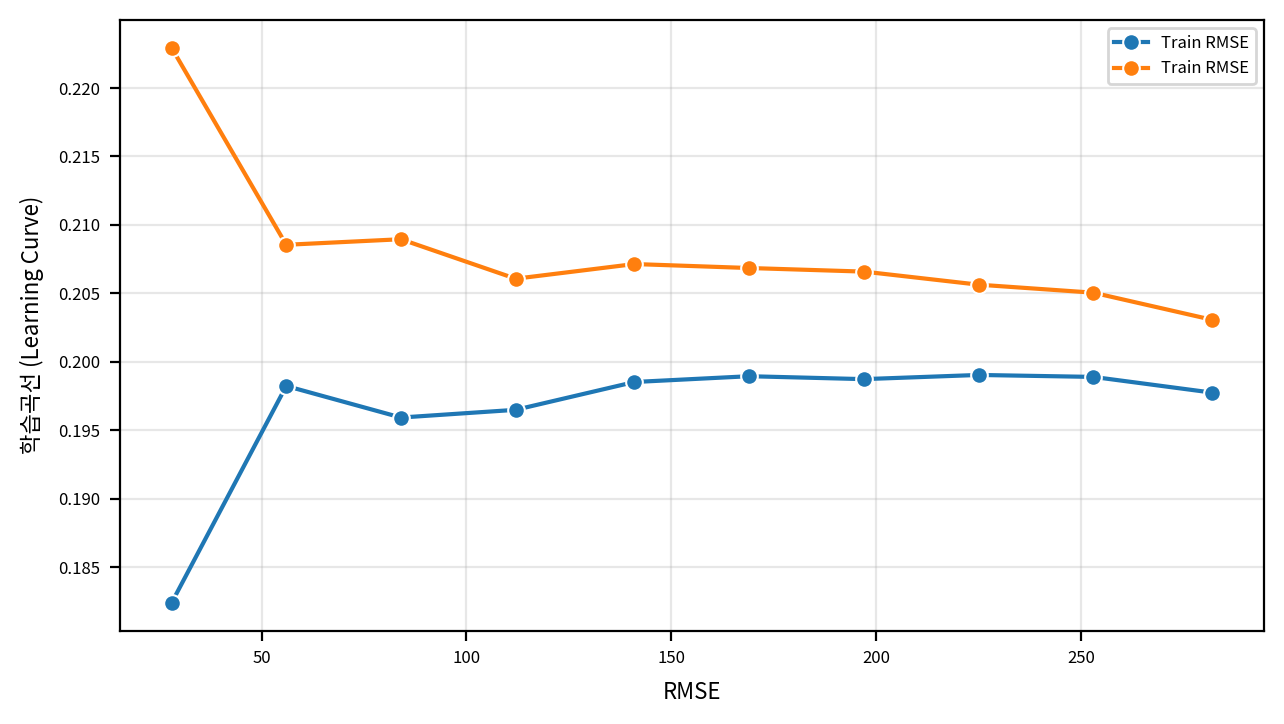

CPU times: total: 203 ms
Wall time: 208 ms


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
Ridge,0.70756,0.156175,0.041835,0.204536,0.009506,0.21884,0.197747,0.203068,0.011856,0.973796,0.058386,⚠️ 판단 유보


In [24]:
%%time

ridge_pipe=Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=52))])

ridge_param_grid={'model__alpha':[0.01, 0.1, 1, 10, 100]}

ridge_gs=GridSearchCV(estimator=ridge_pipe, param_grid=ridge_param_grid, cv=5, scoring='r2', n_jobs=-1)

ridge_gs.fit(x_train, y_train)

ridge_estimator=ridge_gs.best_estimator_

ridge_result_df=hs_get_score_cv(ridge_estimator, x_test, y_test, x, y)
ridge_result_df

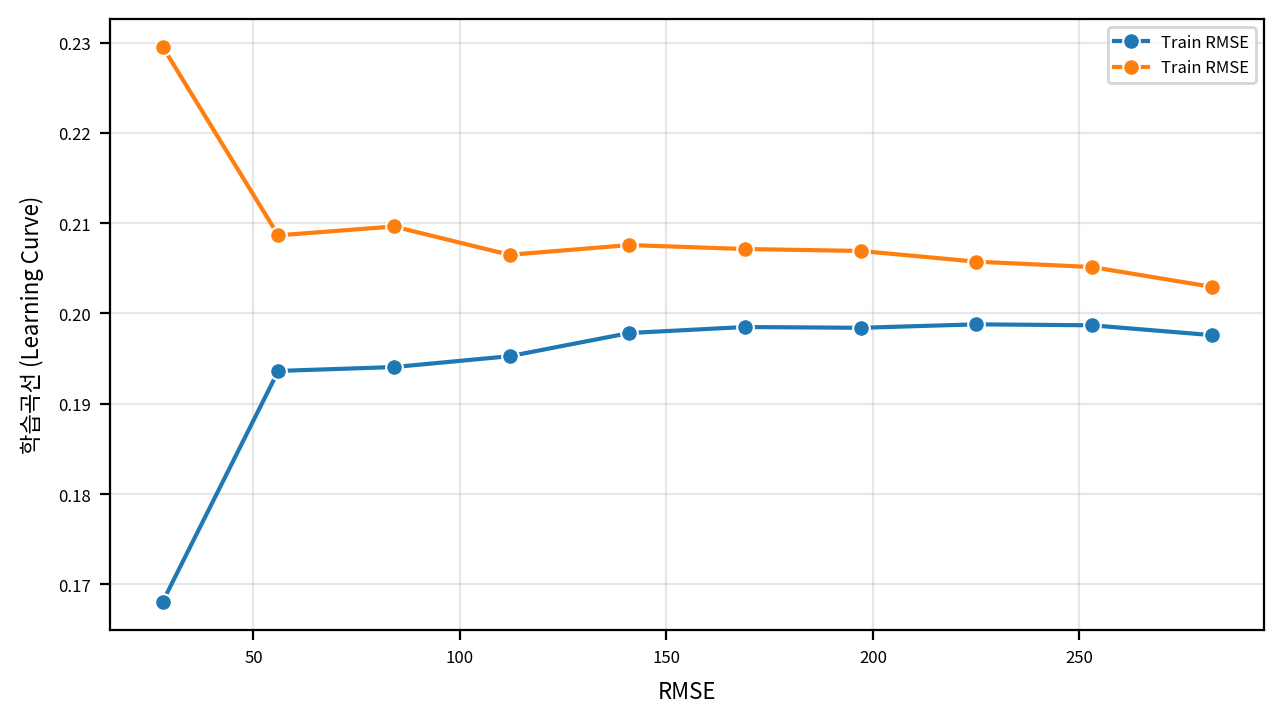

CPU times: total: 219 ms
Wall time: 266 ms


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
ElasticNet,0.709341,0.156105,0.04158,0.203912,0.009503,0.223115,0.197605,0.202954,0.011907,0.973645,0.058667,⚠️ 판단 유보


In [25]:
%%time

en_pipe=Pipeline([('scaler', StandardScaler()), ('model', ElasticNet(random_state=52))])
en_param_grid={'model__alpha':[0.01, 0.1, 1, 10, 100], 'model__l1_ratio':[0.1, 0.5, 0.9]}
en_gs=GridSearchCV(estimator=en_pipe, param_grid=en_param_grid, cv=5, scoring='r2', n_jobs=-1)
en_gs.fit(x_train, y_train)
en_estimator=en_gs.best_estimator_

en_result_df=hs_get_score_cv(en_estimator, x_test, y_test, x, y)
en_result_df


VIF 제거 반복 1회차 =====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.


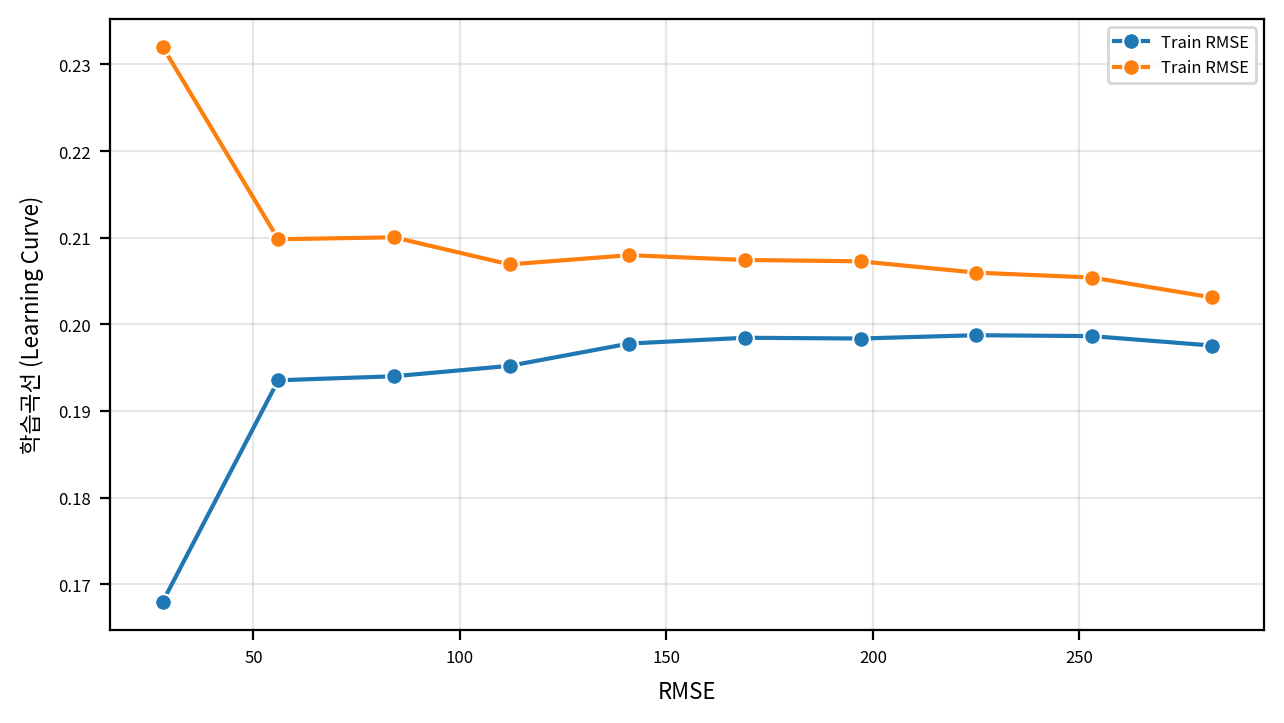

CPU times: total: 281 ms
Wall time: 854 ms


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
LinearRegression,0.70945,0.156402,0.041565,0.203874,0.009521,0.224936,0.197552,0.203111,0.01215,0.97263,0.059819,⚠️ 판단 유보


In [27]:
%%time

linear_pipe=Pipeline([('vif_selector', VIFSelector(check_cols=['visitors', 'avg_price', 'marketing_cost', 'delivery_ratio', 'rain_mm', 'temperature'])),('scaler', StandardScaler()), ('model', LinearRegression(n_jobs=-1))])
linear_param_grid={}
linear_gs=GridSearchCV(estimator=linear_pipe, param_grid=linear_param_grid, cv=5, scoring='r2', n_jobs=-1)
linear_gs.fit(x_train, y_train)
linear_estimator=linear_gs.best_estimator_

linear_result_df=hs_get_score_cv(linear_estimator, x_test, y_test, x, y)
linear_result_df


VIF 제거 반복 1회차 =====================
모든 변수의 VIF가 임계값 이하가 되어 종료합니다. 제거된 변수 0개.


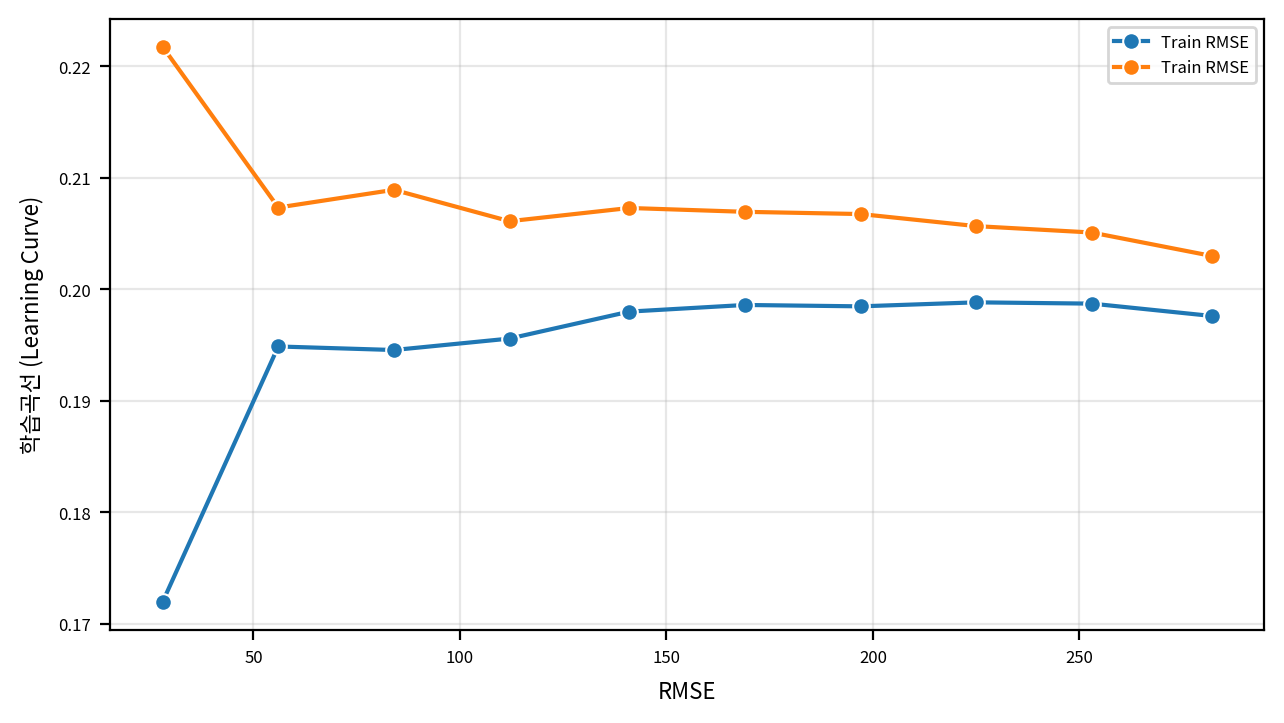

{'weights': [1, 2, 1]}

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
VotingRegressor,0.708573,0.156162,0.04169,0.204181,0.009506,0.221433,0.197627,0.203012,0.011932,0.973475,0.058774,⚠️ 판단 유보


CPU times: total: 453 ms
Wall time: 11 s


In [28]:
%%time

voting_model=VotingRegressor(
    estimators=[
        ('linear', linear_estimator),
        ('ridge', ridge_estimator),
        ('elasticnet', en_estimator)
    ],
    weights=[1,1,1]
)

voting_param_grid={
    'weights':[
        [1,1,1],
        [2,1,1],
        [1,2,1],
        [1,1,2],
        [2,2,1],
        [1,2,2],
        [2,2,2]
    ]
}

voting_gs=GridSearchCV(estimator=voting_model, param_grid=voting_param_grid, cv=5, scoring='r2', n_jobs=-1)
voting_gs.fit(x_train, y_train)
voting_estimator=voting_gs.best_estimator_
voting_best_weights=voting_gs.best_params_

voting_result_df=hs_get_score_cv(voting_estimator, x_test, y_test, x, y)
display(voting_best_weights)
display(voting_result_df)